## Multi-Objective Fitting of TrPL and TrMC Data
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR for fitting transient photoluminescence (TrPL) and transient microwave conductivity (trMC) data with rate equations with a multiobjective approach usingthe [Ax platform](https://ax.dev/) and [BoTorch](https://botorch.org/).

Here we use the following rate equations:

$$\frac{dn}{dt}  = G - k_{trap} n (Bulk_{tr} - n_t) - k_{direct} n (p + p_0)$$
$$\frac{dn_t}{dt}= k_{trap} n (Bulk_{tr} - n_t) - k_{detrap} n_t (p + p_0)$$
$$\frac{dp}{dt} = G - k_{detrap} n_t (p + p_0) - k_{direct} n (p + p_0)$$

where $n$ and $p$ are the electron and hole charge carrier densities, $G$ is the generation rate in m&#8315;&#179; s&#8315;&#185;, k<sub>trap</sub> and k<sub>detrap</sub> are the trapping and detraping rates in m&#179; s&#8315;&#185;, and k<sub>direct</sub> is the bimolecular/band-to-bad recombination rate in m&#179; s&#8315;&#185;.
The TrPL signal is given by:
$$ TrPL = I_{PL} k_{direct} n (p + p_0)$$
where $I_{PL}$ is a scaling factor for the PL signal.  
The TrMC signal is given by:
$$ TrMC = I_{MC} * (r_{\mu}*n + p) $$
where $r_{\mu}$ is the mobility ratio and $I_{MC}$ is a scaling factor for the TrMC signal.

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys,os
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings

In [2]:
# Define the path to the data 
curr_dir = os.getcwd()
parent_dir = os.path.abspath('../') # path to the parent directory if not in Notebooks use os.getcwd()
path2data  = os.path.join(parent_dir,'Example_Data','Christian')
filenames = ['S25D1_L532_F0.csv','S25D1_L532_F1.csv','S25D1_L532_F2.csv'] # list of filenames to be analyzed
res_dir = os.path.join(parent_dir,'temp') # path to the results directory

# Select Gfracs used for the data
Gfracs = [1, 0.552, 0.290, 0.136, 0.087]


# Prepare Experimental Data

In [3]:
# Create a class that contains to do some basic data processing on the data
class Experiment:
    """ A set of measurements """
    def __init__(self, path2data, filenames, Gfracs, laserCenter=0, num_pts=1e3, take_log=False):
        self.path2data = path2data
        self.filenames = filenames
        self.Gfracs = Gfracs
        self.laserCenter = laserCenter
        self.num_pts = num_pts
        self.take_log = take_log
        
        self.get_data()
        pass
    
    
    def get_data(self):
        self.X_raw, self.y_raw_MW, self.y_raw_PL = [],[],[]
        for filename in self.filenames:
            # Create empty lists to store data
            X,y_MW, y_PL = [],[],[]
            
            #Load file and extract data
            with open(os.path.join(self.path2data, filename)) as f:
                for line in f:
                    tmp=line.strip("\n").split(",")
                    X.append(float(tmp[3]))
                    y_MW.append(float(tmp[4]))
                    
                    if len(tmp)>8:
                        y_PL.append(float(tmp[10]))
                    else:
                        raise ValueError("The file does not contain PL data")
            
            # Create output arrays
            self.X_raw.append(np.array(X))
            self.y_raw_MW.append(np.array(y_MW))
            self.y_raw_PL.append(np.array(y_PL))
        pass
    
    
    def process_data(self, cut_rise=False, cut_time=None, cut_sigma=False):
        # Create empty lists to store data
        X_out, y_out_MW, y_out_PL = [],[],[]
        self.X_processed, self.y_processed_MW, self.y_processed_PL = [],[],[]
        self.signalParams={}
        self.background_out_PL=[]
        # Data processing:
        for X, y_MW, y_PL, Gfrac in zip(self.X_raw, self.y_raw_MW, self.y_raw_PL, self.Gfracs):
                
            # Subtract the background from MW and PL data
            index = np.where(X<(-10e-9))  # Calculate the background from the average of the signal up to 10ns before the peak (this buffer is to prevent the rise of the peak to affect the background)
            self.signalParams["MW_background"] = np.mean(y_MW[index])
            self.signalParams["PL_background"] = np.mean(y_PL[index])
            self.signalParams["MW_sigma"] = np.std(y_MW[index])
            self.signalParams["PL_sigma"] = np.std(y_PL[index])
            
            
            y_MW = y_MW - self.signalParams["MW_background"]
            y_PL = y_PL - self.signalParams["PL_background"]
            print('PL Sigma {}, PL background {}, MW Sigma {}, MW background {}'.format(self.signalParams["PL_sigma"],self.signalParams["PL_background"],self.signalParams["MW_sigma"],self.signalParams["MW_background"]))
            
            # Find the peak position
            self.signalParams["index_max_MW"] = np.argmax(abs(y_MW))
            self.signalParams["index_max_PL"] = np.argmax(abs(y_PL))
            
            # Find the sign of the peak
            self.signalParams["sign_max_MW"] = np.sign(y_MW[self.signalParams["index_max_MW"]])
            self.signalParams["sign_max_PL"] = np.sign(y_PL[self.signalParams["index_max_PL"]])
            
            # Remove datapoints at the beginning of the signal
            if cut_rise == "MW":
                index = np.where(X >= X[self.signalParams["index_max_MW"]])
            elif cut_rise == "PL":
                index = np.where(X >= X[self.signalParams["index_max_PL"]])
            elif cut_rise == "Time":
                index = np.where(X > cut_time)
            else:
                index = np.where(X > self.laserCenter)
                
            X = X[index]
            # Remove datapoints before the laser peak from the MW and PL signal and make sure, that the peak is positive
            y_MW = y_MW[index]*self.signalParams["sign_max_MW"]
            y_PL = y_PL[index]*self.signalParams["sign_max_PL"]
            
            # Remove datapoints that aren't significant enough (in either measurement)
            if cut_sigma:
                sigma = float(cut_sigma)
                index = np.where((np.abs(y_MW)>sigma*self.signalParams["MW_sigma"]) & (np.abs(y_PL)>sigma*self.signalParams["PL_sigma"]))

                X = X[index]
                y_MW = y_MW[index]
                y_PL = y_PL[index]
            
            
            # Interpolate to get num_pts
            X_interp = np.geomspace(X[1],X[-1],int(self.num_pts))

            # Add 0 to the beginning of X_interp
            X_interp = np.insert(X_interp,0,0)
            y_interp_MW = np.interp(X_interp,X,y_MW)
            y_interp_PL = np.interp(X_interp,X,y_PL)

            # Take the log of the data
            if self.take_log:
                y_interp_MW = np.log10(y_interp_MW)
                y_interp_PL = np.log10(y_interp_PL)
                
                # Remove all data points where either signal is NaN
                mask_NaNs = np.logical_or(np.isnan(y_interp_PL), np.isnan(y_interp_MW))
                X_interp = X_interp[~mask_NaNs]
                y_interp_MW = y_interp_MW[~mask_NaNs]
                y_interp_PL = y_interp_PL[~mask_NaNs]
                print('Removed {} Data Points while taking the logarithm!'.format(np.count_nonzero(mask_NaNs)))
            
            # Append the data to the output
            for i in range(len(X_interp)):
                X_out.append([X_interp[i],Gfrac])
                y_out_MW.append(y_interp_MW[i])
                y_out_PL.append(y_interp_PL[i])
                self.background_out_PL.append(self.signalParams["PL_sigma"]*np.sqrt(2/np.pi))
                
            self.X_processed.append(np.array(X_interp))
            self.y_processed_MW.append(np.array(y_interp_MW))
            self.y_processed_PL.append(np.array(y_interp_PL))

        # Convert the output to arrays
        self.X = np.array(X_out)
        self.y_MW = np.array(y_out_MW)
        self.y_PL = np.array(y_out_PL)
        pass

PL Sigma 2.9602988876119335e-05, PL background -0.003598912016122306, MW Sigma 3.780285415804477e-05, MW background -0.0007008701257225716
Removed 132 Data Points while taking the logarithm!
PL Sigma 3.0399603508164594e-05, PL background -0.003610847480546366, MW Sigma 4.040993545427417e-05, MW background -0.0008486578742130771
Removed 154 Data Points while taking the logarithm!
PL Sigma 2.5489343983201138e-05, PL background -0.0031102876606446113, MW Sigma 3.75774071903544e-05, MW background -0.0009373141997225259
Removed 164 Data Points while taking the logarithm!


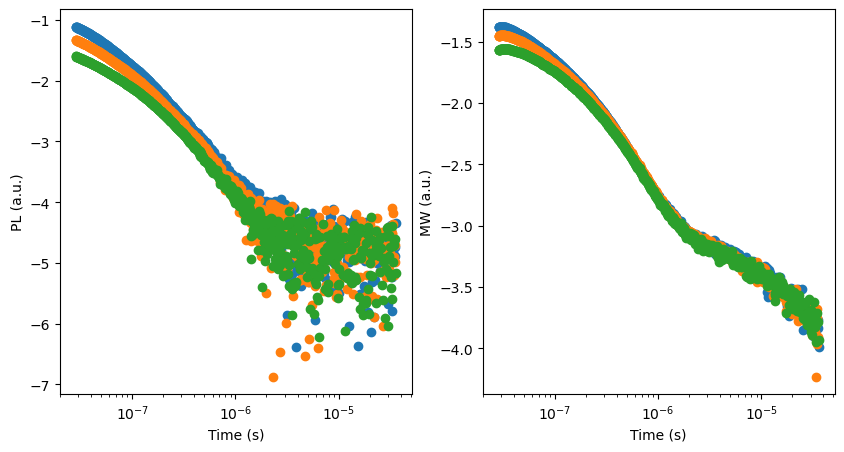

In [4]:
# Load the data and process it
data = Experiment(path2data, filenames, Gfracs, laserCenter=2.8E-8, take_log=True)
data.process_data(cut_rise=False, cut_time=None ,cut_sigma=0)
X = data.X
y_MW = data.y_MW
y_PL = data.y_PL
back_PL = data.background_out_PL

# Make a plot with 2 subplots for PL and MW
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i in range(len(data.X_processed)):
    ax1.semilogx(data.X_processed[i], data.y_processed_PL[i], 'o', label=data.Gfracs[i])
    ax2.semilogx(data.X_processed[i], data.y_processed_MW[i], 'o', label=data.Gfracs[i])

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('PL (a.u.)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('MW (a.u.)')

# Assign weights based on the signal strength
weight_PL = 1/(np.abs(y_PL))
weight_MW = 1/(np.abs(y_MW))


# Define the free parameters to be optimized

In [5]:
# define Fitparameters
True_values = {'kdirect': 3.9e-17, 'ktrap': 4e-18, 'kdetrap':3.1e-18,'Bulk_tr':1.6e23,'p_0':0, 'QE': 1, 'I_PL': 1e-32, 'N0': 1.04103e24, 'r_mu':4.2, 'I_MC':2.2e-26} # Contains a good set of parameters for the model to fit the data

params = []

# PL only parameters

I_PL = Fitparam(name = 'I_PL', val =  True_values['I_PL'], lims = [5e-33, 6e-32], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'I$_{PL}$',unit='')
params.append(I_PL)


# MW only parameters

I_MC = Fitparam(name = 'I_MC', val =  True_values['I_MC'], lims = [7e-27, 8e-26], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'I$_{MC}$',unit='')
params.append(I_MC)

r_mu = Fitparam(name = 'r_mu', val =  True_values['r_mu'], lims = [0.5, 10], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'r$_\mu$',unit='')
params.append(r_mu)


# Parameters for both

kdirect = Fitparam(name = 'kdirect', val =  True_values['kdirect'], lims = [9e-18,9e-17], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params.append(kdirect)

ktrap = Fitparam(name = 'ktrap', val = True_values['ktrap'], lims = [1e-19, 9e-18] , relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'k$_{trap}$',unit='m$^{3}$ s$^{-1}$')
params.append(ktrap)

kdetrap = Fitparam(name = 'kdetrap', val =  True_values['kdetrap'], lims = [8e-19, 8e-17], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'k$_{detrap}$',unit='m$^{3}$ s$^{-1}$')
params.append(kdetrap)

Bulk_tr = Fitparam(name = 'Bulk_tr', val =  True_values['Bulk_tr'], lims = [7e21, 9e23], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'N$_T$',unit='m$^{-3}$')
params.append(Bulk_tr)

p_0 = Fitparam(name = 'p_0', val =  True_values['p_0'], lims = [1e17, 1.5e25], relRange = 0, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'p$_0$',unit='m$^{-3}$')
params.append(p_0)


# Currently unused parameters

QE = Fitparam(name = 'QE', val =  True_values['QE'], lims = [0.02, 1], relRange = 0, range_type = 'linear',
            lim_type = 'absolute',optim_type = 'linear', display_name = 'QE',unit='')
params.append(QE)

N0 = Fitparam(name = 'N0', val =  True_values['N0'], lims = [6.5e21, 6.5e25], relRange = 0, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'N$_0$',unit='m$^{-3}$')
params.append(N0)

In [6]:
# Define the experimental conditions 
fpu = 1e3 # pump frequency in Hz
background = 0 # background carrier density in m^-3
N_init = 1.04103e24 # initial carrier density from the pulse in m^-3

# Initialize the agents for the TrPL and TrMC models
func = partial(Bimolecular_Trapping_Detrapping_equation, solver_func='odeint', method='Radau')
trPL = TrPL_agent(trPL_model = func)
trPL.pump_params['fpu'] = fpu
trPL.pump_params['N0'] = N_init
trPL.pump_params['background'] = 0

# create trMC agent
trMC = TrMC_agent(trMC_model = func)
trMC.pump_params['fpu'] = fpu
trMC.pump_params['N0'] = N_init
trMC.pump_params['background'] = 0


In [7]:
# Define a wrapper function for the PL model to match the experimental conditions by adding a background offset to the PL signal due to the measurement setup
def trPL_wrap(X,params,X_dimensions=[],take_log=False,back_PL=0):
    signal = trPL.trPL(X,params,X_dimensions=X_dimensions,take_log=False)
    for i in range(len(signal)):
        signal[i] = signal[i] + back_PL[i]
    if take_log:
        signal = np.log10(signal)
        #Check if the signal contains any NaNs
        if np.isnan(signal).any():
            
            # Split data into datasets with different G_fracs
            Gfs = set(X[:,1])
            for Gf in Gfs:
                index = np.where(Gf == X[:,1])
                signal_temp = signal[index]
                X_temp = X[index]
                if np.isnan(signal_temp).any():
                    # Create a mask to filter out all NaNs
                    mask_NaNs = np.isnan(signal_temp)
                    # Signal and X without NaNs:
                    X_interp = X_temp[~mask_NaNs]
                    signal_temp = signal_temp[~mask_NaNs]
                    signal_interp = np.interp(X_temp[:,0], X_interp[:,0], signal_temp)
                    signal[index] = signal_interp     
        if np.isnan(signal).any():
            raise ValueError("Signal contains NaN(s)")
    return signal

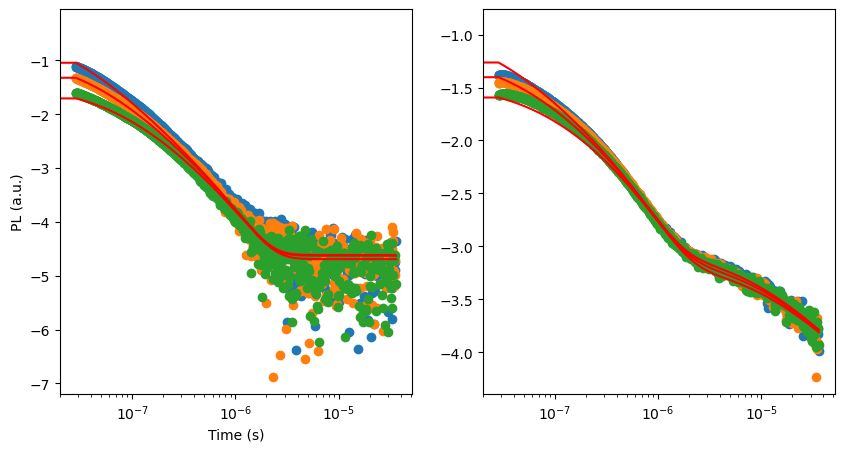

In [8]:
# test the model with the predefine parameters from True_values (obtained from a previous run)
X_dimensions = ['t','Gfrac']
y_PL_model = trPL_wrap(X,params,X_dimensions=X_dimensions,take_log=True, back_PL=back_PL)
y_MC_model = trMC.trMC(X,params,X_dimensions=X_dimensions,take_log=True)

# plot PL
fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for i in range(len(data.X_processed)):
    ax1.semilogx(data.X_processed[i], data.y_processed_PL[i], 'o', label="PL")
    
for i in range(len(data.X_processed)):   
    ax1.semilogx(data.X_processed[i], y_PL_model[np.where(X[:,1]==data.Gfracs[i])], '-', color='red')
    
    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('PL (a.u.)')

# plot MW
for i in range(len(data.X_processed)):
    ax2.semilogx(data.X_processed[i], data.y_processed_MW[i], 'o', label="MW")
    
for i in range(len(data.X_processed)):   
    ax2.semilogx(data.X_processed[i], y_MC_model[np.where(X[:,1]==data.Gfracs[i])], '-', color='red')

plt.show()


# Start the optimization

In [9]:
# Define the targets and the models
X_dimensions = ['t','Gfrac']
y_dimension = 'PL [a.u.]'

target = {'model':partial(trPL_wrap,X_dimensions=X_dimensions,take_log=True, back_PL = back_PL),'target_name':'trPL',
          'data':{'X':X,'y':y_PL,'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

y_dimension = '$MW$ [a.u.]'

target2 = {'model':partial(trMC.trMC,X_dimensions=X_dimensions,take_log=True),'target_name':'trMC',
           'data':{'X':X,'y':y_MW,'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

targets = [target, target2]
obj_type='MSE'#'hausdorff'
loss='linear'
threshold=0.5#50

mo = MooBOtorch(params=params, targets= targets) # initialize the optimization object
kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':True_values,'show_points':True,'savefig':False,'figname':'param_posterior','full_grid':True,'randomize':True}

ax_client = mo.BoTorchOpti(n_jobs=[10,2], n_step_points = [80, 120], models=['Sobol','MOO'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=True,verbose=True,show_posterior=True,kwargs_posterior=kwargs_posterior)

[INFO 09-20 10:04:58] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 09-20 10:04:58] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='I_PL', parameter_type=FLOAT, range=[-32.30102999566398, -31.221848749616356]), RangeParameter(name='I_MC', parameter_type=FLOAT, range=[-26.154901959985743, -25.096910013008056]), RangeParameter(name='r_mu', parameter_type=FLOAT, range=[-0.3010299956639812, 1.0]), RangeParameter(name='kdirect', parameter_type=FLOAT, range=[-17.045757490560675, -16.045757490560675]), RangeParameter(name='ktrap', parameter_type=FLOAT, range=[-19.0, -17.045757490560675]), RangeParameter(name='kdetrap', parameter_type=FLOAT, range=[-18.096910013008056, -16.096910013008056]), RangeParameter(name='Bulk_tr', parameter_type=FLOAT, range=[21.845098040014257, 23.954242509439

In [10]:
# Print the optimized fit parameters
for p in mo.params:
    if p.axis_type == 'log':
        print(p.display_name + f' {p.val:.2e} {p.unit}')
    else:
        print(p.display_name + f' {p.val:.2f} {p.unit}')

I$_{PL}$ 2.51e-32 
I$_{MC}$ 2.17e-26 
r$_\mu$ 4.94e+00 
k$_2$ 4.53e-17 m$^{3}$ s$^{-1}$
k$_{trap}$ 5.83e-19 m$^{3}$ s$^{-1}$
k$_{detrap}$ 1.96e-18 m$^{3}$ s$^{-1}$
N$_T$ 7.25e+23 m$^{-3}$
p$_0$ 0.00e+00 m$^{-3}$
QE 1.00 
N$_0$ 1.04e+24 m$^{-3}$


In [11]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
print(triedX.head())
triedY = ax_client.experiment.fetch_data().df
print(triedY.head())

[INFO 09-20 10:17:15] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


   Generation Step Generation Model  Trial Index Trial Status  \
0                0            Sobol            0    COMPLETED   
1                0            Sobol            1    COMPLETED   
2                0            Sobol            2    COMPLETED   
3                0            Sobol            3    COMPLETED   
4                0            Sobol            4    COMPLETED   

                               Arm Parameterizations  
0  {'0_0': {'I_PL': -32.0, 'I_MC': -25.58, 'r_mu'...  
1  {'1_0': {'I_PL': -31.79, 'I_MC': -25.7, 'r_mu'...  
2  {'2_0': {'I_PL': -31.32, 'I_MC': -26.11, 'r_mu...  
3  {'3_0': {'I_PL': -31.99, 'I_MC': -25.67, 'r_mu...  
4  {'4_0': {'I_PL': -32.29, 'I_MC': -25.16, 'r_mu...  
  arm_name metric_name      mean  sem  trial_index
0      0_0    MSE_trPL  0.285056  NaN            0
1      0_0    MSE_trMC  0.197088  NaN            0
2      1_0    MSE_trPL  0.159458  NaN            1
3      1_0    MSE_trMC  0.132185  NaN            1
4      2_0    MSE_trPL  

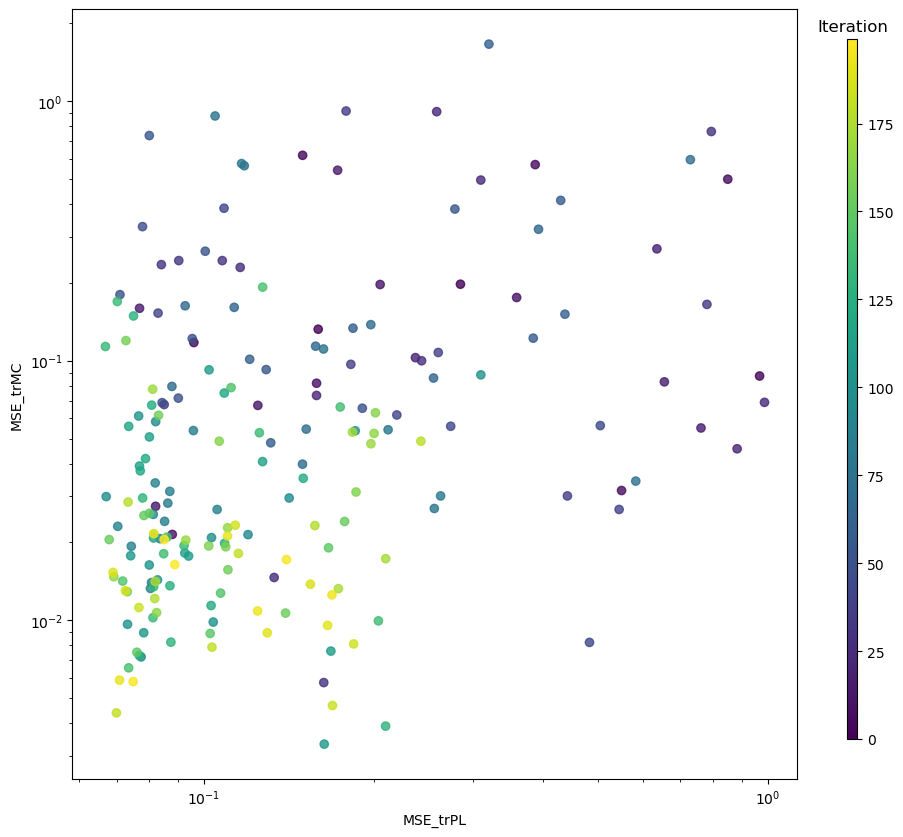

In [12]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=True,figsize=(10,10))

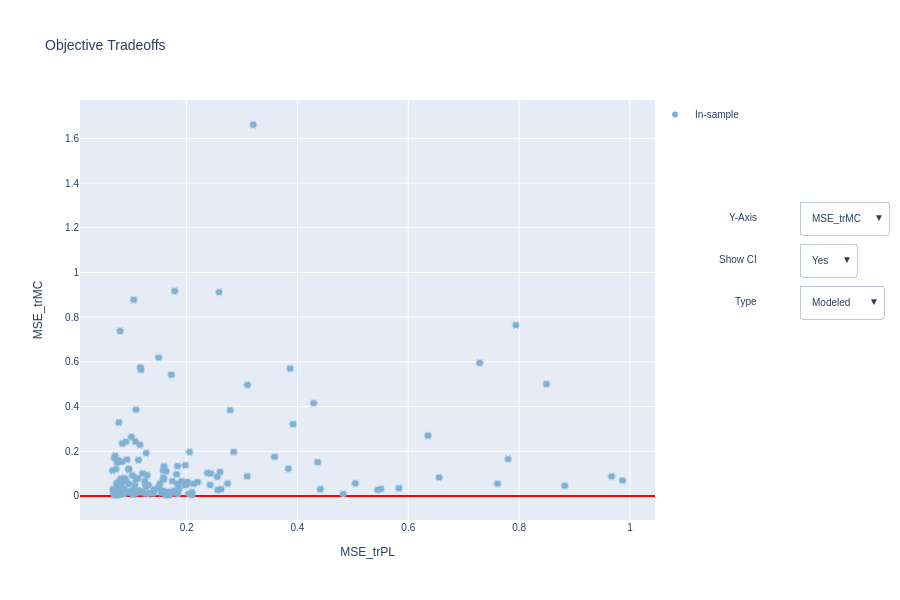

In [13]:
# Interactive plotting of the objective function tradeoffs
model = ax_client.generation_strategy.model
render(plot_objective_vs_constraints(model, obj_type+'_'+targets[0]['target_name'], rel=False))

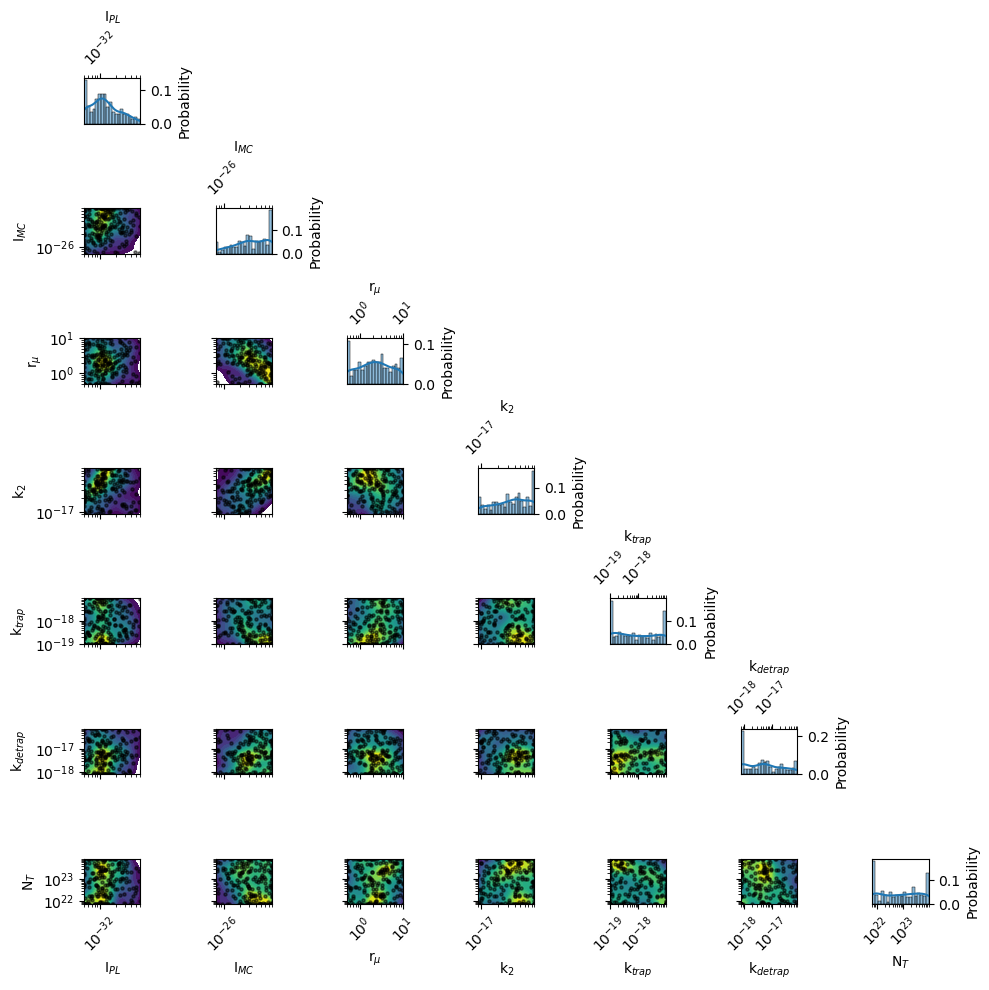

In [14]:
# Plot the density of points that were sampled during the optimization process
mo.plot_density(ax_client,figsize=(10,10))

[INFO 09-20 10:17:25] ax.service.ax_client: Retrieving contour plot with parameter 'kdirect' on X-axis and 'ktrap' on Y-axis, for metric 'MSE_trPL'. Remaining parameters are affixed to the middle of their range.


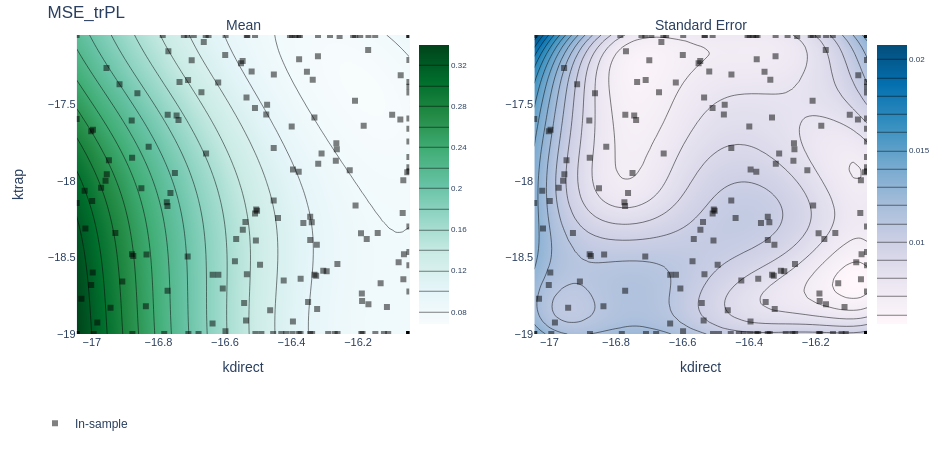

In [15]:
# Plot the contour of the objective function for a given target
render(ax_client.get_contour_plot(param_x="kdirect", param_y="ktrap", metric_name=obj_type+'_'+targets[0]['target_name']))

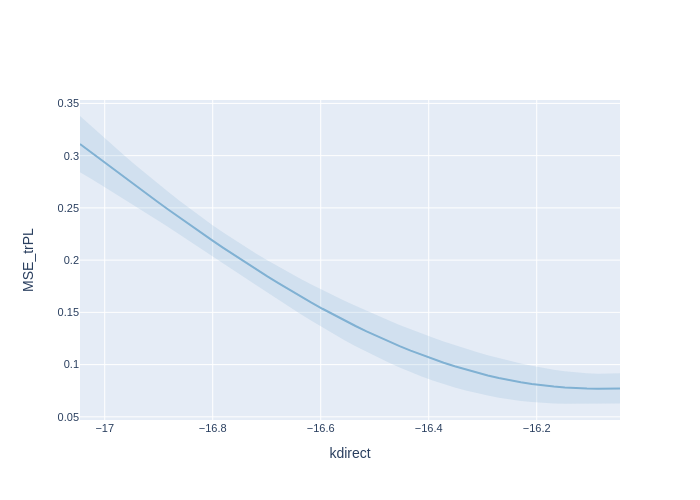

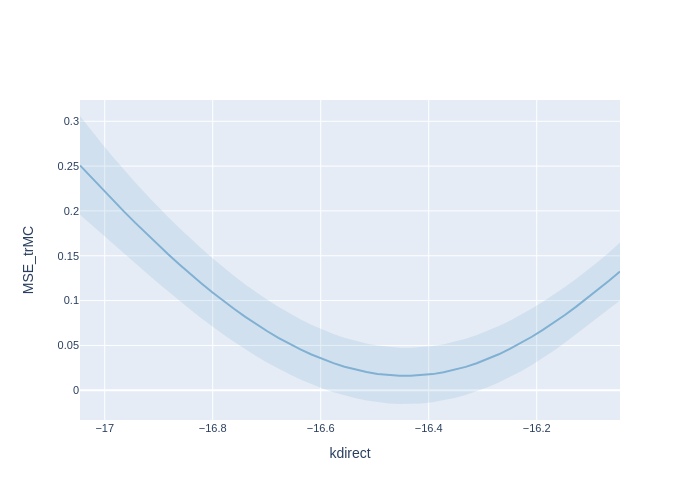

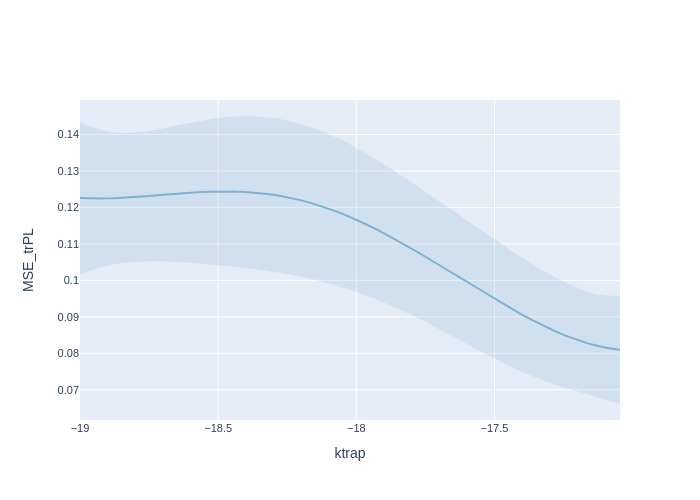

In [16]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
render(plot_slice(model, "kdirect", "MSE_trPL"))
render(plot_slice(model, "kdirect", "MSE_trMC"))
render(plot_slice(model, "ktrap", "MSE_trPL"))

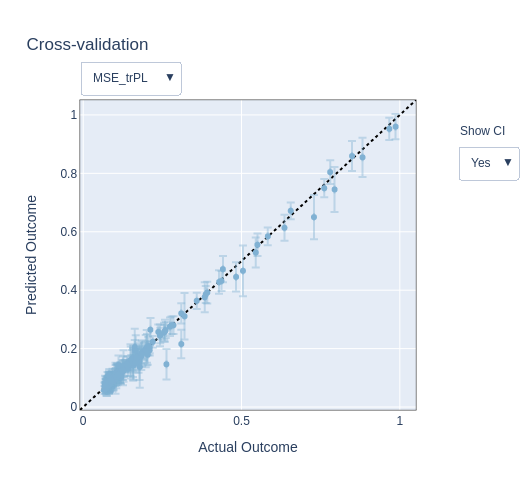

In [17]:
# Plot the results of cross validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

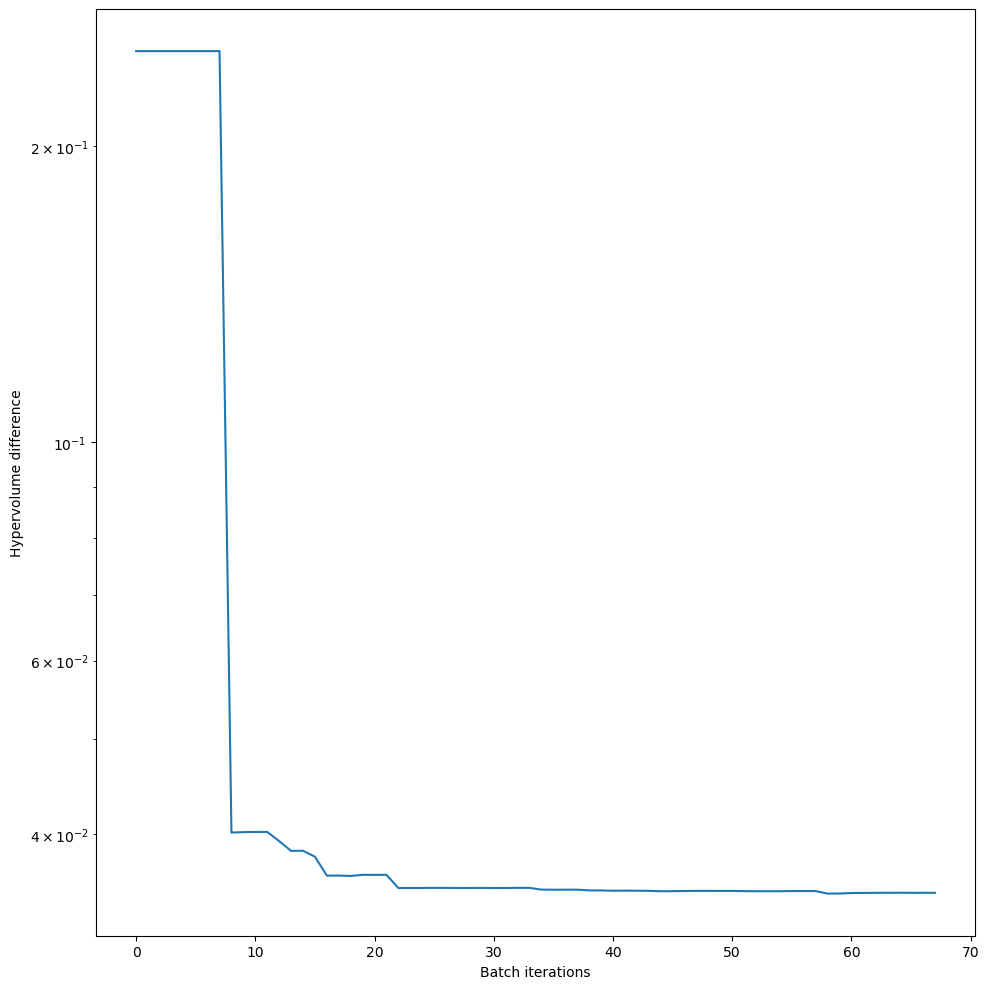

In [18]:
# Plot the hypervolume evolution during the optimization
mo.plot_hypervolume(logscale=True,figsize=(10,10))

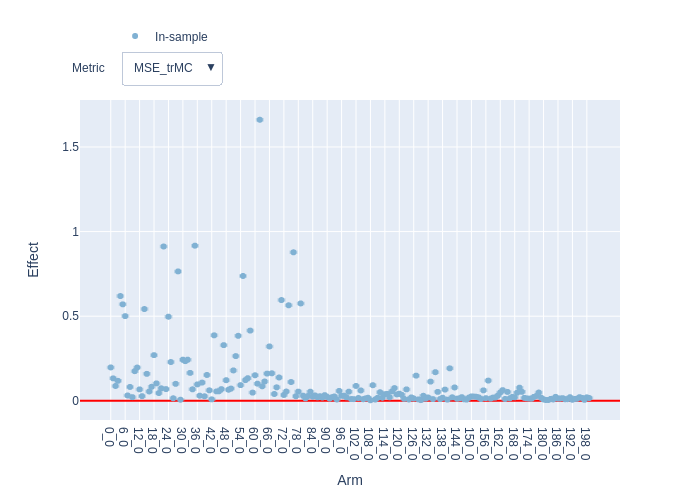

In [19]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False))

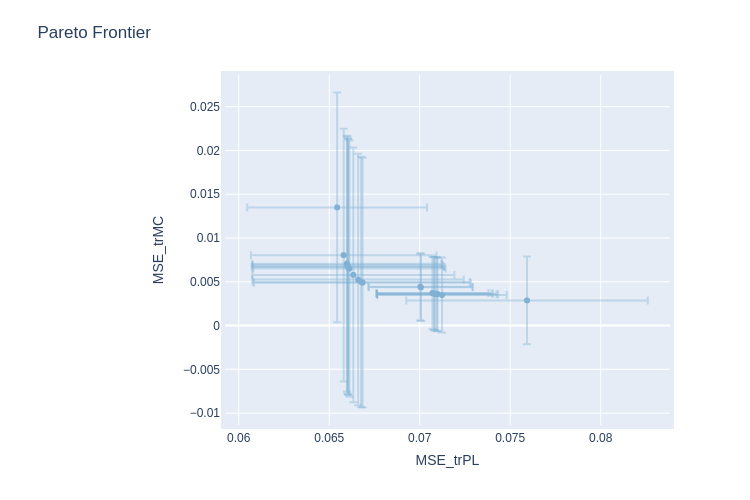

In [20]:
# Compute and plot the Pareto frontier
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["MSE_trPL", "MSE_trMC"],
    num_points=20,
)
render(plot_pareto_frontier(frontier, CI_level=0.90)) 

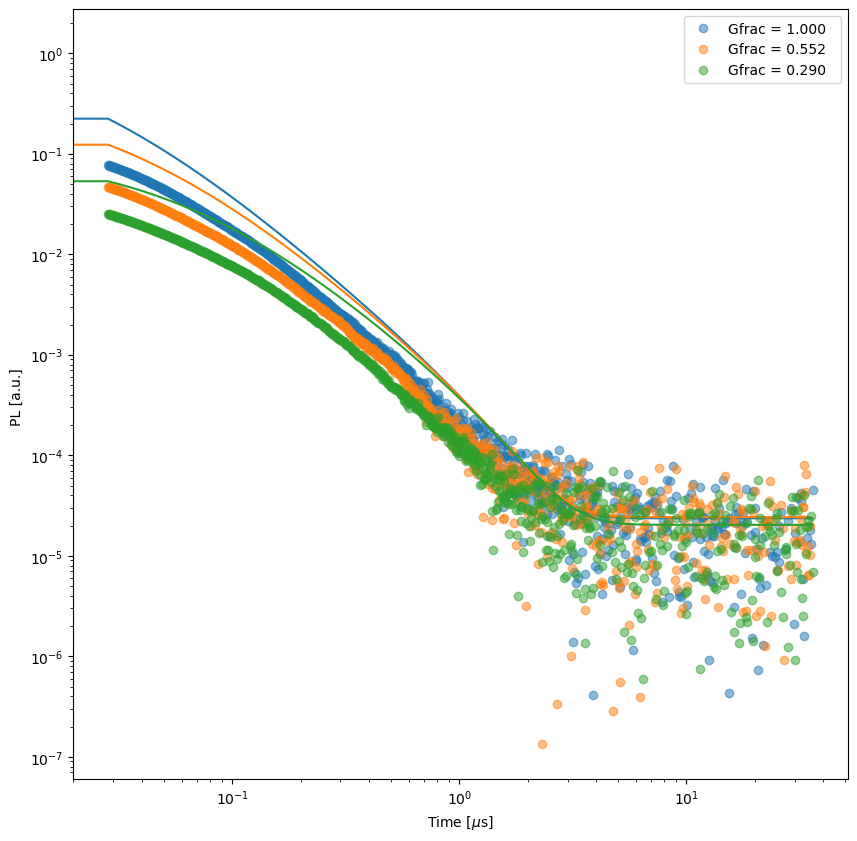

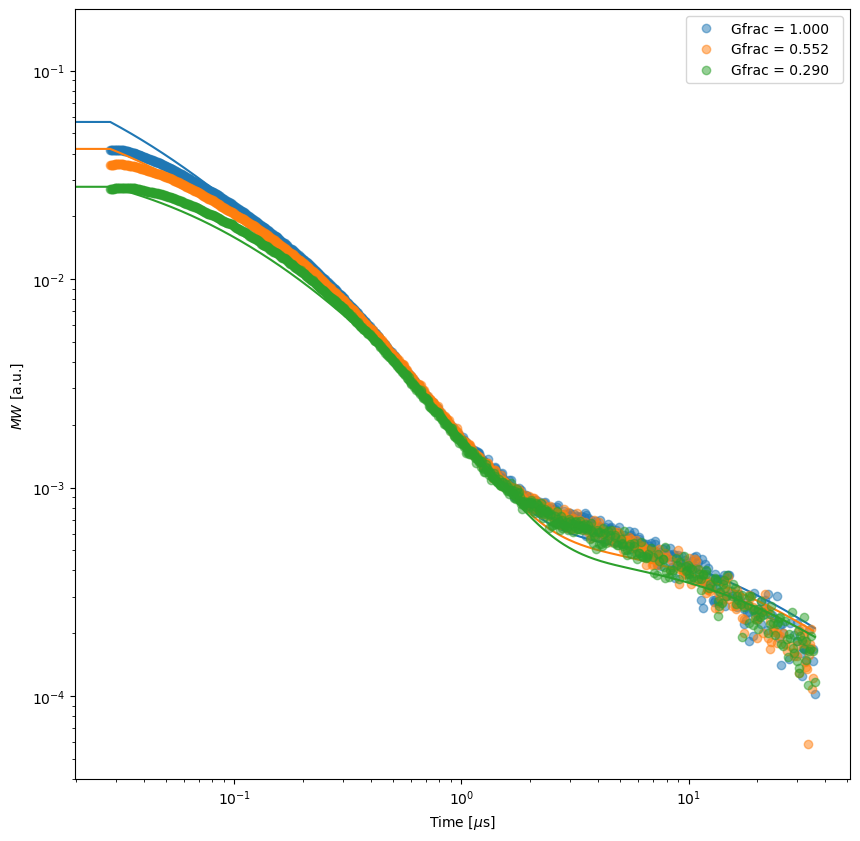

In [21]:
# Plot and save the results
fit_results = []
kwargs_plot_res = {'x_scaling':1e6,'xaxis_label':'Time [$\mu$s]','xscale_type':'log','yscale_type':'log','norm_data':False,'delog':True,'figsize':(10,10)}

for num,t in enumerate(targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    #trPL.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[1e-6,1],kwargs=kwargs_plot_res)
    trPL.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = trPL.get_param_dict(mo.params) # get fitparameters (and fixed ones)

pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]


# produce output excel file with data, fitparameters and FOMs
fn_xlsx = 'fits_results_BO.xlsx'
namecols = X_dimensions + ['Jexp','Jfit']
# delete old file if it exists
if os.path.exists(os.path.join(res_dir,fn_xlsx)):
    os.remove(os.path.join(res_dir,fn_xlsx))

with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
    for i,t in enumerate(targets):
        if 'target_name' in t.keys():
            tname = t['target_name']
        else: 
            tname = 'data'
        namecols = X_dimensions + [tname+'_exp',tname+'_fit']
        df = pd.DataFrame(fit_results[i],columns=namecols)
        df.to_excel(writer, sheet_name = tname+f'_{i}')
       
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = f'params')

# Gradient descent
Use curve fit to fine tune the parameters of the model starting from the best parameters found with the Bayesian optimization this help to give a better fit to the data without wasting time with longer Bayesian optimization runs for the fine tuning.  
Note that using curve_fit alone without the Bayesian optimization is not recommended especially in high dimensional space and wide parameter ranges as it might get stick in local minima or take a long time to converge if the initial guess is not good.

In [22]:
best_params = deepcopy(mo.params) # get the best parameters

for p in mo.params:
    p.startVal = p.val # reset the start values to the best ones before starting the gradient descent

kwargs_curve =  {'ftol':1e-8, 'xtol':1e-6, 'gtol': 1e-8, 'diff_step':0.001,'loss':'linear','maxfev':100}
print('Start curve fit')
try:
    rc = mo.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')
    mo.params = deepcopy(best_params) #reset the parameters to the best ones

Start curve fit


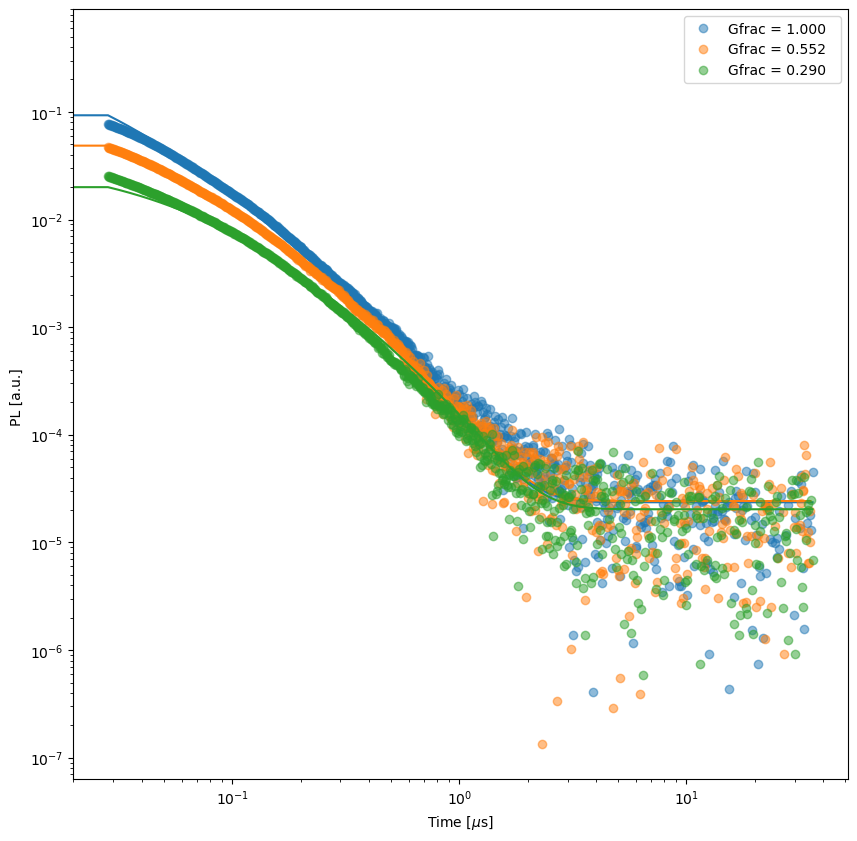

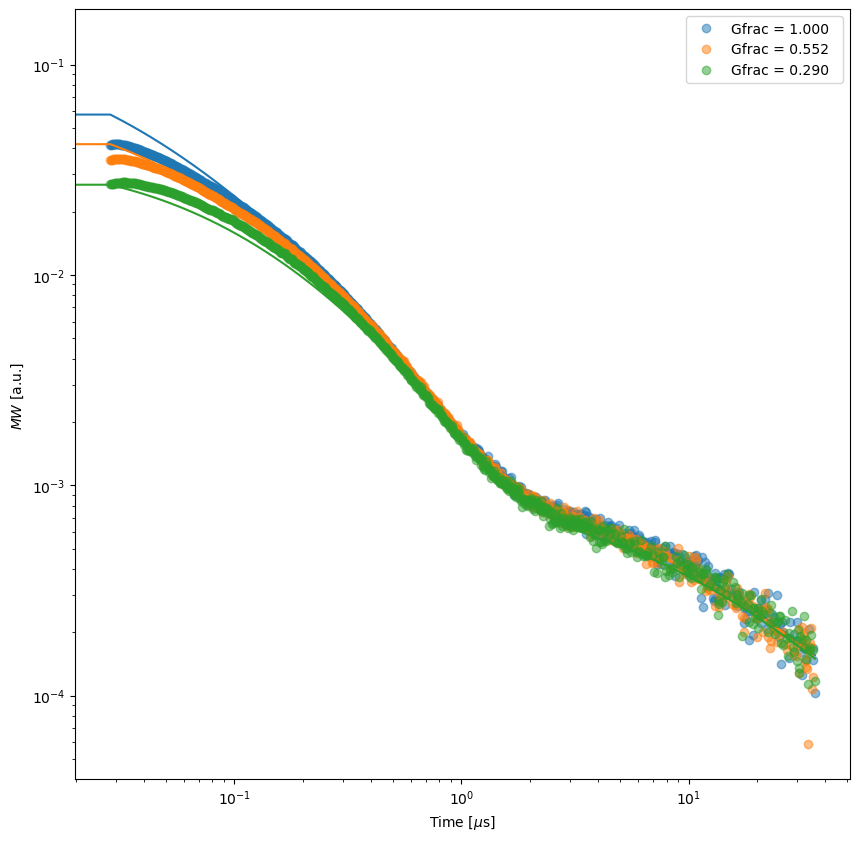

In [23]:
# Plot and save the results
fit_results = []
kwargs_plot_res = {'x_scaling':1e6,'xaxis_label':'Time [$\mu$s]','xscale_type':'log','yscale_type':'log','norm_data':False,'delog':True,'figsize':(10,10)}

for num,t in enumerate(targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    #trPL.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[1e-6,1],kwargs=kwargs_plot_res)
    trPL.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = trPL.get_param_dict(mo.params) # get fitparameters (and fixed ones)

pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]


# produce output excel file with data, fitparameters and FOMs
fn_xlsx = 'fits_results.xlsx'
namecols = X_dimensions + ['Jexp','Jfit']
# delete old file if it exists
if os.path.exists(os.path.join(res_dir,fn_xlsx)):
    os.remove(os.path.join(res_dir,fn_xlsx))

with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
    for i,t in enumerate(targets):
        if 'target_name' in t.keys():
            tname = t['target_name']
        else: 
            tname = 'data'
        namecols = X_dimensions + [tname+'_exp',tname+'_fit']
        df = pd.DataFrame(fit_results[i],columns=namecols)
        df.to_excel(writer, sheet_name = tname+f'_{i}')
       
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = f'params')

In [24]:
# Print the optimized fit parameters
for p in mo.params:
    if p.axis_type == 'log':
        print(p.display_name + f' {p.val:.2e} {p.unit}')
    else:
        print(p.display_name + f' {p.val:.2f} {p.unit}')

I$_{PL}$ 1.03e-32 
I$_{MC}$ 2.20e-26 
r$_\mu$ 4.46e+00 
k$_2$ 3.80e-17 m$^{3}$ s$^{-1}$
k$_{trap}$ 9.00e-18 m$^{3}$ s$^{-1}$
k$_{detrap}$ 3.35e-18 m$^{3}$ s$^{-1}$
N$_T$ 9.78e+22 m$^{-3}$
p$_0$ 0.00e+00 m$^{-3}$
QE 1.00 
N$_0$ 1.04e+24 m$^{-3}$
